### Import packages

In [51]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

### Retrieve training data

In [52]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)

pickle_in = open('../data/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

### OLS One Time Function
- Function takes the X_train dataframe and y_train numpy array
- Returns the ols_model (model) and the ols model summary report (results)

In [53]:
def onetime_ols(X_train, y_train):
    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    model = ols_model.fit()
    results = model.summary()
    
    return model, results

### OLS Loop Function
- Function takes an X_train df and a y_train numpy array
- Also takes a run variable, used to track iterative loops through the function
- Returns x_chop, or the columns to be removed from the model based on thier p-values
- Also returns run_dict, a dictionary that captures parameters of the test

In [54]:
def ols_loop(X_train, y_train, run):

    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    est = ols_model.fit()
    results = est.summary()

    # Capture r2_adj 
    r2_adj = est.rsquared_adj

    # Load summary info into dataframe for processing
    results_as_html = results.tables[1].as_html()
    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'index':'feature'})
    results_df = results_df[1:]

    # Identify highest p-value in data set
    kill_cols = results_df[results_df['P>|t|'] == results_df['P>|t|'].max()]
    highest_p_col = kill_cols['feature'].values
    highest_p = kill_cols['P>|t|'].values

    # Remove feature with highest p-value
    X_chop = X_train.drop(columns=highest_p_col)

    # Capture values from test in dictionary
    run_dict = {'test_run': run, \
            'r2_adj': r2_adj, \
            'highest_feature': highest_p_col,\
            'highest_pval': highest_p[0]}
    
    return X_chop, run_dict

### View initial regression

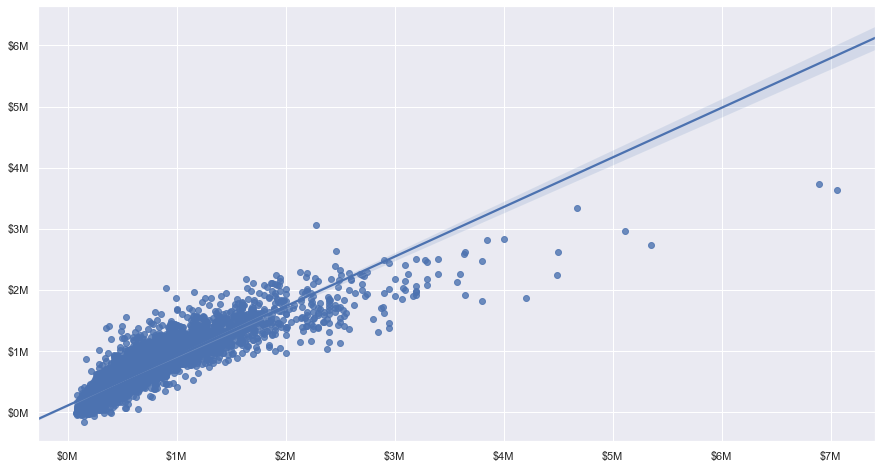

In [55]:
# Fit a multiple linear regression to the X and y train data
og_model, results = onetime_ols(X_train, y_train)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

# Review P>|t| values from generated results_df
results_df;

# Review r2 adjusted and other statistical results with the full summary
onetime_ols(X_train, y_train);

# Generate predicted prices from model
y_pred = og_model.predict()

# Plot predicted values
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

tr = sns.regplot(x=y_train, y=y_pred);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in tr.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in tr.get_xticks()/1000000]
tr.set_xticklabels(xlabels);
tr.set_yticklabels(ylabels);

# ## Look at the residuals as well, yellowbrick package for residual plots
# ### y_train - y_pred on y and then y_train on x axis

## Key takeaway:  The regression line looks good up to around 2.5 million.  At this point the predicted values are all above the actual values.  Hints at a polynomial relationship.

In [85]:
r2adj = og_model.rsquared_adj
print('Model\'s R2 adjusted value equals {}'.format(r2adj))

Model's R2 adjusted value equals 0.8119659862774881


### View initial residual plot

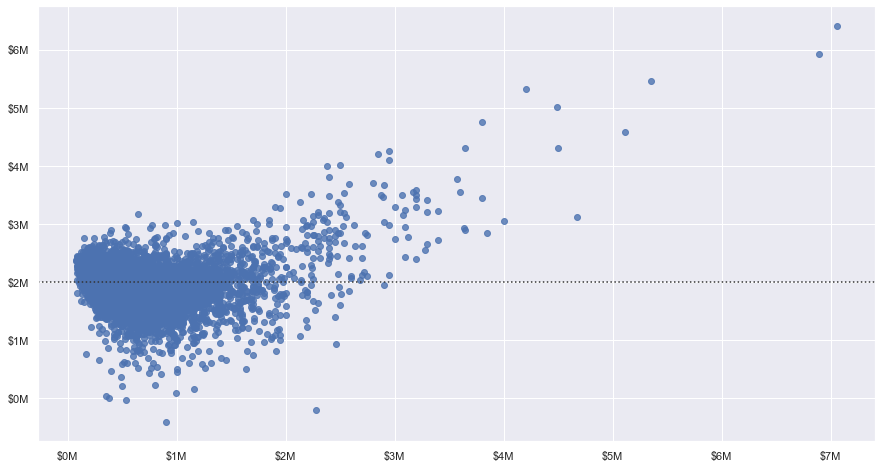

In [56]:
# Define x and y axis
xax = y_train
yax = y_train - y_pred

# Create sns graph
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

resid = sns.residplot(x=xax, y=yax);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in resid.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in resid.get_xticks()/1000000]
resid.set_xticklabels(xlabels);
resid.set_yticklabels(ylabels);

## This confirms the prior assumtion that this is a polynomial relationship.  The residuals steadily increase as the price increases after roughly 2.25 million dollars.

### Create a polynomial regression 

In [66]:
# Create polynomial regression using sklearn
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
poly_model = pol_reg.fit(X_poly, y_train);

In [67]:
# Generate predicted values
y_pred_poly = pol_reg.predict(X_poly)

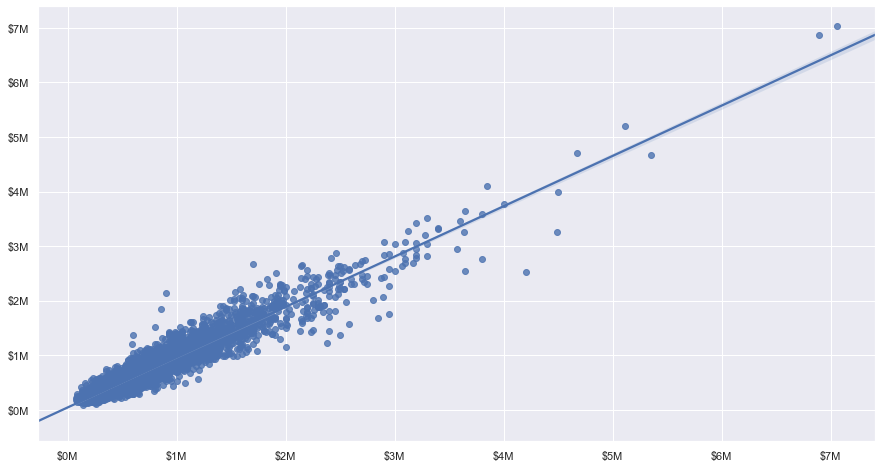

In [68]:
# Plot polynomial regression values
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

poly = sns.regplot(x=y_train, y=y_pred_poly);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in poly.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in poly.get_xticks()/1000000]
poly.set_xticklabels(xlabels);
poly.set_yticklabels(ylabels);

### Much nicer, let's take a look at the residuals

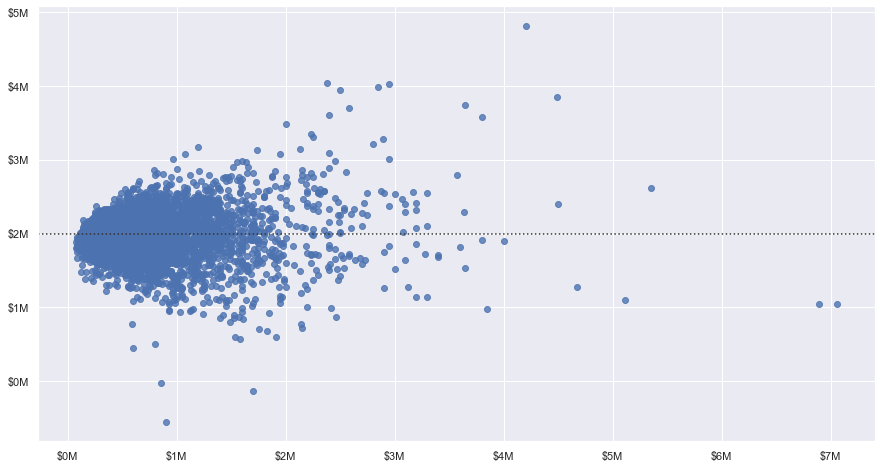

In [69]:
# Define x and y axis
xax = y_train
yax = y_train - y_pred_poly

# Create sns graph
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

resid_poly = sns.residplot(x=xax, y=yax);

xlabels = ['${:,.0f}'.format(x) + 'M' for x in resid_poly.get_xticks()/1000000]
ylabels = ['${:,.0f}'.format(y) + 'M' for y in resid_poly.get_xticks()/1000000]
resid_poly.set_xticklabels(xlabels);
resid_poly.set_yticklabels(ylabels);

### This regression model is more appropriate.

In [88]:
poly_r2 = poly_model.score(X_poly, y_train)
print('The r2 for this regression equals {}, an improvement of {} compared to the linear regression'\
      .format(poly_r2, poly_r2 - r2adj))

The r2 for this regression equals 0.9194468621419986, an improvement of 0.1074808758645105 compared to the linear regression
